## Importing libraries and fetching the data

In [1]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import IntBias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit
from torch.utils.data import Dataset, DataLoader
from brevitas.export.onnx.generic.manager import BrevitasONNXManager
from finn.util.inference_cost import inference_cost
import json, os, h5py, copy
import torch.nn.utils.prune as prune
from utils import load_checkpoint, plot_confusion_matrix, calculate_cost
from dataset_loader import radioml_18_dataset
from Baseline import get_baseline_network
from network import AaronNet
import seaborn as sns
import pandas as pd

In [2]:
gpu = 0
if torch.cuda.is_available():
    torch.cuda.device(gpu)
    print("Using GPU %d" % gpu)
else:
    gpu = None
    print("Using CPU only")

Using GPU 0


In [3]:
# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# ُSpecify the dataset_path
dataset_path = "/home/aaron/5g/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
dataset = radioml_18_dataset(dataset_path)

## Competition Baseline Model

In [5]:
model_vgg = get_baseline_network()

## Proposed Model

In [6]:
config_32 = {
    "conv_layers": [
        #filters, ksize, padding, w_bits, a_bits, pool, bias
        [33, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [40, 3, 1, 6, 6, 2, True],
    ],
    "linear_layers": [48, 6, 6, True]
}

config_48 = {
    "conv_layers": [
        #filters, ksize, padding, w_bits, a_bits, pool, bias
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
    ],
    "linear_layers": [48, 6, 6, True]
}

In [7]:
model_48p = AaronNet(config_48, 6)
model_32 = AaronNet(config_32, 6)
model_32pp = AaronNet(config_32, 6)

## Loading checkpoints for all models

In [8]:
vgg_pth = "./checkpoints/vgg.pth"
aaron32_pth = "./checkpoints/main.pth"
aaron32pp_pth = "./checkpoints/pruned.pth"
aaron48p_pth = "./checkpoints/high_acc.pth"

# Load trained parameters
saved_state_vgg = torch.load(vgg_pth, map_location=torch.device("cpu"))
saved_state_aaron32 = torch.load(aaron32_pth, map_location=torch.device("cpu"))
saved_state_aaron32pp = torch.load(aaron32pp_pth, map_location=torch.device("cpu"))
save_state_aaron48p = torch.load(aaron48p_pth, map_location=torch.device("cpu"))

model_vgg.load_state_dict(saved_state_vgg)
model_32.load_state_dict(saved_state_aaron32)
model_32pp.load_state_dict(saved_state_aaron32pp)
model_48p.load_state_dict(save_state_aaron48p)

if gpu is not None:
    model_vgg = model_vgg.cuda()
    model_32 = model_32.cuda()
    model_32pp = model_32pp.cuda()
    model_48p = model_48p.cuda()

## A new dataloader

In [9]:
# Set up a fresh test data loader
batch_size = 1024
dataset = radioml_18_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [10]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))

y_pred_vgg = np.empty((0, len(dataset.mod_classes)))
model_32 = np.empty((0, len(dataset.mod_classes)))
model_32pp = np.empty((0, len(dataset.mod_classes)))
model_48p = np.empty((0, len(dataset.mod_classes)))

model_vgg.eval()
model_32.eval()
model_32pp.eval()
model_48p.eval()

iter_ = 0

with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        if gpu is not None:
            inputs = inputs.cuda()
        output_vgg = model_vgg(inputs)
        output_aaron32 = model_32(inputs)
        output_aaron32pp = model_32pp(inputs)
        output_aaron48p = model_48p(inputs)
        
        y_pred_vgg = np.concatenate((y_pred_vgg, output_vgg.cpu()))
        y_pred_aaron32 = np.concatenate((y_pred_aaron32, output_aaron32.cpu()))
        y_pred_aaron32pp = np.concatenate(y_pred_aaron32pp, output_aaron32pp.cpu()))
        y_pred_aaron48p = np.concatenate((y_pred_aaron48p, output_aaron48p.cpu()))
        
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

In [11]:
conf_vgg = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
conf_aaron32 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
conf_aaron32pp = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
conf_aaron48p = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])


confnorm_vgg = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm_aaron32 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm_aaron32pp = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm_aaron48p = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])

for i in range(len(y_exp)):
    j = int(y_exp[i])
    k_vgg = int(np.argmax(y_pred_vgg[i,:]))
    k_aaron32 = int(np.argmax(y_pred_aaron32[i,:]))
    k_aaron32pp = int(np.argmax(y_pred_aaron32pp[i,:]))
    k_aaron48p = int(np.argmax(y_pred_aaron48p[i,:]))
    conf_vgg[j,k_vgg] = conf_vgg[j,k_vgg] + 1
    conf_aaron32[j,k_aaron32] = conf_aaron32[j,k_aaron32] + 1
    conf_aaron32pp[j,k_aaron32pp] = conf_aaron32pp[j,k_aaron32pp] + 1
    conf_aaron48p[j,k_aaron48p] = conf_aaron48p[j,k_aaron48p] + 1
    
for i in range(0,len(dataset.mod_classes)):
    confnorm_vgg[i,:] = conf_vgg[i,:] / np.sum(conf_vgg[i,:])
    confnorm_aaron32[i,:] = conf_aaron32[i,:] / np.sum(conf_aaron32[i,:])
    confnorm_aaron32pp[i,:] = conf_aaron32pp[i,:] / np.sum(conf_aaron32pp[i,:])
    confnorm_aaron48p[i,:] = conf_aaron48p[i,:] / np.sum(conf_aaron48p[i,:])

cor_vgg = np.sum(np.diag(conf_vgg))
ncor_vgg = np.sum(conf_vgg) - cor_vgg
print("VGG Accuracy across all SNRs: %f"%(cor_vgg / (cor_vgg+ncor_vgg)))

cor_baseline = np.sum(np.diag(conf_aaron32))
ncor_baseline = np.sum(conf_aaron32) - cor_baseline
print("AaronNet Accuracy across all SNRs: %f"%(cor_baseline / (cor_baseline+ncor_baseline)))

cor_pruned = np.sum(np.diag(conf_aaron32pp))
ncor_pruned = np.sum(conf_aaron32pp) - cor_pruned
print("Pruned AaronNet Accuracy across all SNRs: %f"%(cor_pruned / (cor_pruned+ncor_pruned)))

cor_pruned = np.sum(np.diag(conf_aaron48p))
ncor_pruned = np.sum(conf_aaron48p) - cor_pruned
print("Pruned AaronNet Accuracy across all SNRs: %f"%(cor_pruned / (cor_pruned+ncor_pruned)))

VGG Accuracy across all SNRs: 0.594669
AaronNet Accuracy across all SNRs: 0.584971
Pruned AaronNet Accuracy across all SNRs: 0.560772
Pruned AaronNet Accuracy across all SNRs: 0.600739


## Confusion matrix of pruned model

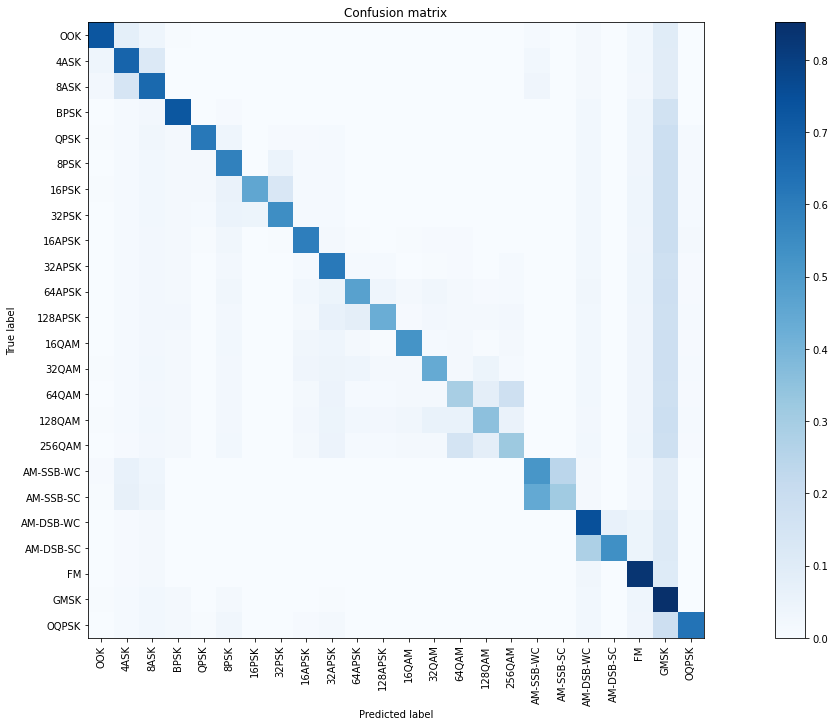

In [12]:
plt.figure(figsize=(20,10))
plot_confusion_matrix(confnorm_pruned, labels=dataset.mod_classes)

In [13]:
acc_vgg = []
acc_proposed_baseline = []
acc_proposed_pruned = []
acc_best = []


for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i1 = y_pred_vgg[indices_snr]
    y_pred_i2 = y_pred_aaron32[indices_snr]
    y_pred_i3 = y_pred_aaron32pp[indices_snr]
    y_pred_i4 = y_pred_aaron48p[indices_snr]
 
    conf_v1 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    conf_v2 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    conf_v3 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    conf_v4 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm_v1 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm_v2 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm_v3 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm_v4 = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k1 = int(np.argmax(y_pred_i1[i,:]))
        k2 = int(np.argmax(y_pred_i2[i,:]))
        k3 = int(np.argmax(y_pred_i3[i,:]))
        k4 = int(np.argmax(y_pred_i4[i,:]))
        
        conf_v1[j,k1] = conf_v1[j,k1] + 1
        conf_v2[j,k2] = conf_v2[j,k2] + 1
        conf_v3[j,k3] = conf_v3[j,k3] + 1
        conf_v4[j,k4] = conf_v4[j,k4] + 1
        
    for i in range(0,len(dataset.mod_classes)):
        confnorm_v1[i,:] = conf_v1[i,:] / np.sum(conf_v1[i,:])
        confnorm_v2[i,:] = conf_v2[i,:] / np.sum(conf_v2[i,:])
        confnorm_v3[i,:] = conf_v3[i,:] / np.sum(conf_v3[i,:])
        confnorm_v4[i,:] = conf_v4[i,:] / np.sum(conf_v4[i,:])
        
 
    cor_v1 = np.sum(np.diag(conf_v1))
    cor_v2 = np.sum(np.diag(conf_v2))
    cor_v3 = np.sum(np.diag(conf_v3))
    cor_v4 = np.sum(np.diag(conf_v4))
    
    ncor_v1 = np.sum(conf_v1) - cor_v1
    ncor_v2 = np.sum(conf_v2) - cor_v2
    ncor_v3 = np.sum(conf_v3) - cor_v3
    ncor_v4 = np.sum(conf_v4) - cor_v4
    
    acc_vgg.append(cor_v1/(cor_v1 + ncor_v1))
    acc_aaron32.append(cor_v2 / (cor_v2 + ncor_v2))
    acc_aaron32pp.append(cor_v3 / (cor_v3 + ncor_v3))
    acc_aaron48p.append(cor_v4 / (cor_v4 + ncor_v4))

## Accuracy over different SNRs

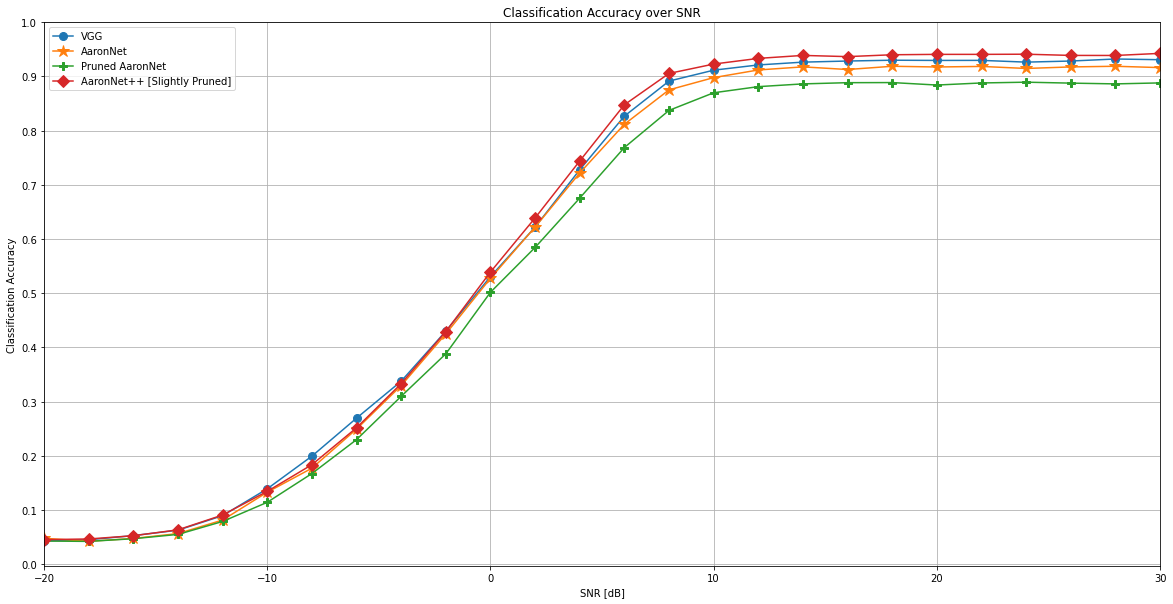

In [14]:
plt.figure(figsize=(20,10))
plt.plot(dataset.snr_classes, acc_vgg, marker='o', markersize=8)
plt.plot(dataset.snr_classes, acc_aaron32, marker='*', markersize=12)
plt.plot(dataset.snr_classes, acc_aaron32pp, marker='P', markersize=8)
plt.plot(dataset.snr_classes, acc_aaron48p, marker='D', markersize=8)
plt.legend(['VGG', 'AaronNet32', 'AaronNet32++','AaronNet48+'])
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR")
plt.show()

## Cost calculation of different models

In [15]:
print("VGG -- Baseline Competition")
VGGBops, VGGWBits, VGGCost = calculate_cost(model_vgg, "vgg")

VGG -- Baseline Competition
Inference cost for ./Models/vgg_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 130328.0,
  "mem_w_SCALEDINT8": 155617.0,
  "op_mac_SCALEDINT8_SCALEDINT8": 388096.0,
  "op_mac_SCALEDUINT8_SCALEDINT8": 12232215.0,
  "total_bops": 807699904.0,
  "total_mem_o_bits": 4170496.0,
  "total_mem_w_bits": 1244936.0,
  "unsupported": "set()"
}
Ops is 0.5, w_bits is 0.5
Normalized inference cost score: 1.000000


In [16]:
print("AaronNet -- Baseline")
AaronNetBops, AaronNetWBits, AaronNetCost = calculate_cost(proposed_baseline, "base")

AaronNet -- Baseline
Inference cost for ./Models/base_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 49275.0,
  "mem_w_SCALEDINT6": 12491.0,
  "op_mac_FLOAT32_SCALEDINT6": 47548.0,
  "op_mac_SCALEDINT6_SCALEDINT6": 406060.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 557462.0,
  "total_bops": 43816008.0,
  "total_mem_o_bits": 1576800.0,
  "total_mem_w_bits": 74946.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.02712394032920425, w_bits is 0.030100342507566654
Normalized inference cost score: 0.057224


In [17]:
print("AaronNet -- Highest Accuracy")
AaronNetPlusPlusPrunedBops, AaronNetPlusPlusPrunedWBits, AaronNetPlusPlusPrunedCost = calculate_cost(proposed_best, "large_slightly_pruned")

AaronNet -- Highest Accuracy
Inference cost for ./Models/large_slightly_pruned_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 72504.0,
  "mem_w_SCALEDINT6": 8667.0,
  "op_mac_FLOAT32_SCALEDINT6": 46246.0,
  "op_mac_SCALEDINT6_SCALEDINT6": 304545.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 450443.0,
  "total_bops": 36058800.0,
  "total_mem_o_bits": 2320128.0,
  "total_mem_w_bits": 52002.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.022321904349266827, w_bits is 0.02088541097694982
Normalized inference cost score: 0.043207


In [18]:
print("AaronNet -- Proposed Model")
AaronNetPrunedBops, AaronNetPrunedWBits, AaronNetPrunedCost = calculate_cost(proposed_pruned, "base_pruned")

AaronNet -- Proposed Model
Inference cost for ./Models/base_pruned_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 49275.0,
  "mem_w_SCALEDINT6": 3085.0,
  "op_mac_FLOAT32_SCALEDINT6": 24609.0,
  "op_mac_SCALEDINT6_SCALEDINT6": 113080.0,
  "op_mac_SCALEDUINT6_SCALEDINT6": 112929.0,
  "total_bops": 12861252.0,
  "total_mem_o_bits": 1576800.0,
  "total_mem_w_bits": 18510.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.007961652549608325, w_bits is 0.007434117095175977
Normalized inference cost score: 0.015396


## Visualizing Binary Operations, WeightBits and Inference Cost

In [50]:
data = np.array([
    VGGCost, AaronNetCost, AaronNetPlusPlusPrunedCost, AaronNetPrunedCost
]).reshape((1, -1))
classes = ["VGG", "AaronNet32", "AaronNet48+", "AaronNet32++"]
df = pd.DataFrame(data, columns=classes)

,VGG,AaronNet,AaronNet++ Slightly Pruned,AaronNet Pruned
0,1.0,0.057224,0.043207,0.015396


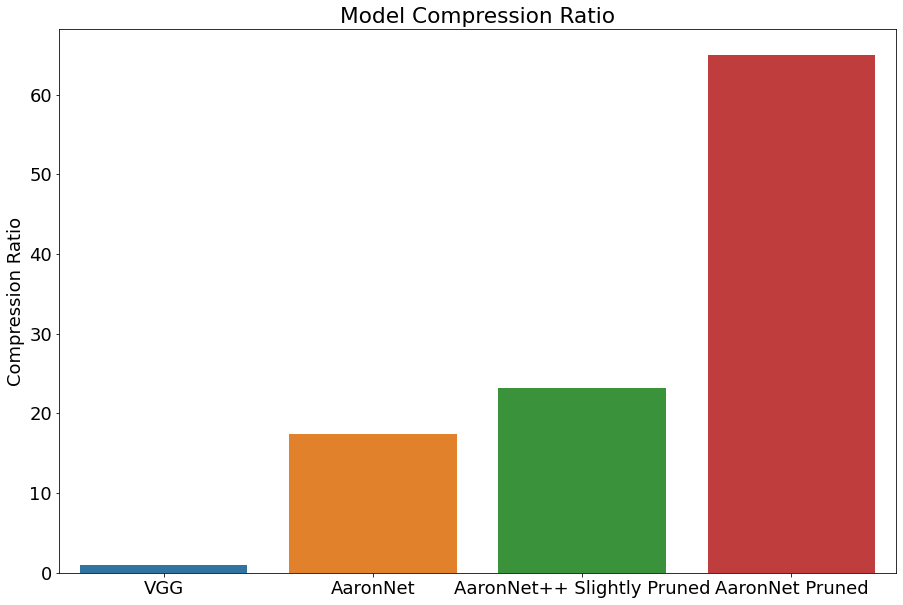

In [80]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(15, 10))
plt.title("Model Compression Ratio")
plt.ylabel("Compression Ratio")
sns.barplot(x=classes, y=1.0/data.reshape(-1, ))
plt.show()